# NF Modeled Timing Resolution
### Plot the learned distribution against the true optical photon simulation distribution

* Utilize pre-trained NF model to sample timings
* Calculate timing resolution of sampled timings
* Calculate timing resolution of optical photon hit times
* Compare std and mean of first hit timing distribution

## Setup
**Package imports:**

In [56]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from IPython.display import clear_output
import time
from concurrent.futures import ThreadPoolExecutor
import matplotlib.ticker as plticker
import os
from typing import Union, List
from scipy.stats import norm
import os

import datetime
today = datetime.datetime.now().strftime("%B_%d")

**local imports (written by me):**

In [57]:
from NF_util import process_data, create_dataloader, prepare_data_for_nn,\
    create_unique_mapping,process_data_one_segment,\
    prepare_data_for_nn_one_segment, PVect, calculate_num_pixels_z_dependence,theta_func, r_func,load_real_data, process_times,get_all_times,checkdir

In [58]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
def get_compiled_NF_model(thickness = "2cm", useGPU = True):
    if(thickness == "1cm"):
        run_num = 7
        run_num_str = str(run_num)

        #NF Stuff

        K = 8 #num flows

        latent_size = 1 #dimension of PDF
        hidden_units = 256 #nodes in hidden layers
        hidden_layers = 26
        context_size = 3 #conditional variables for PDF
        num_context = 3

        K_str = str(K)
        batch_size= 2000
        hidden_units_str = str(hidden_units)
        hidden_layers_str = str(hidden_layers)
        batch_size_str = str(batch_size)
        flows = []
        for i in range(K):
            flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                                     num_context_channels=context_size)]
            flows += [nf.flows.LULinearPermute(latent_size)]

        # Set base distribution
        q0 = nf.distributions.DiagGaussian(1, trainable=False)

        # Construct flow model
        model = nf.ConditionalNormalizingFlow(q0, flows)

        model_path = "/hpc/group/vossenlab/rck32/NF_time_res_models/"
        if(useGPU):
            model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth")
        else:
            state_dict = torch.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth",  map_location=torch.device('cpu'))
            model.load_state_dict(state_dict)
            model.to(torch.device('cpu'))
        model_compiled = torch.compile(model,mode = "reduce-overhead").to(device)
    elif(thickness == "2cm"):
        run_num = 1
        run_num_str = str(run_num)

        #NF Stuff

        K = 8 #num flows

        latent_size = 1 #dimension of PDF
        hidden_layers = 26
        hidden_units = 256 #nodes in hidden layers
        context_size = 3 #conditional variables for PDF
        num_context = 3
        batch_size= 20000
        K_str = str(K)
        hidden_units_str = str(hidden_units)
        hidden_layers_str = str(hidden_layers)
        batch_size_str = str(batch_size)
        flows = []
        for i in range(K):
            flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                                     num_context_channels=context_size)]
            flows += [nf.flows.LULinearPermute(latent_size)]

        # Set base distribution
        q0 = nf.distributions.DiagGaussian(1, trainable=False)

        # Construct flow model
        model = nf.ConditionalNormalizingFlow(q0, flows)

        model_path = "/hpc/group/vossenlab/rck32/NF_time_res_models/thicker_2cm/"
        if(useGPU):
            model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs_checkpoint_e13.pth")
        else:
            state_dict = torch.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs_checkpoint_e13.pth", map_location=torch.device('cpu'))
            model.load_state_dict(state_dict)
            model.to(torch.device('cpu'))
        model_compiled = torch.compile(model,mode = "reduce-overhead").to(device)
    elif(thickness == "2cm_1point8ns_time_constant"):
        run_num = 3
        run_num_str = str(run_num)

        #NF Stuff

        K = 12 #num flows

        latent_size = 1 #dimension of PDF
        hidden_layers = 26
        hidden_units = 256 #nodes in hidden layers
        context_size = 3 #conditional variables for PDF
        num_context = 3
        batch_size= 15000
        K_str = str(K)
        hidden_units_str = str(hidden_units)
        hidden_layers_str = str(hidden_layers)
        batch_size_str = str(batch_size)
        flows = []
        for i in range(K):
            flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                                     num_context_channels=context_size)]
            flows += [nf.flows.LULinearPermute(latent_size)]

        # Set base distribution
        q0 = nf.distributions.DiagGaussian(1, trainable=False)

        # Construct flow model
        model = nf.ConditionalNormalizingFlow(q0, flows)

        model_path = "/hpc/group/vossenlab/rck32/eic/work_eic/macros/NF_timing_modeling/models/June_11/run_4_20mm_scint_1point8_time_constant3context_12flows_26hl_256hu_15000bs_finished.pth"
        if(useGPU):
            model.load(model_path)
        else:
            state_dict = torch.load(model_path, map_location=torch.device('cpu'))
            model.load_state_dict(state_dict)
            model.to(torch.device('cpu'))
        model_compiled = torch.compile(model,mode = "reduce-overhead").to(device)
    elif(thickness == "2cm_1point8ns_time_constant_run_6"):
        run_num = 6
        run_num_str = str(run_num)

        #NF Stuff

        K = 6 #num flows

        latent_size = 1 #dimension of PDF
        hidden_layers = 8
        hidden_units = 128 #nodes in hidden layers
        context_size = 3 #conditional variables for PDF
        num_context = 3
        batch_size= 15000
        K_str = str(K)
        hidden_units_str = str(hidden_units)
        hidden_layers_str = str(hidden_layers)
        batch_size_str = str(batch_size)
        flows = []
        for i in range(K):
            flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                                     num_context_channels=context_size)]
            flows += [nf.flows.LULinearPermute(latent_size)]

        # Set base distribution
        q0 = nf.distributions.DiagGaussian(1, trainable=False)

        # Construct flow model
        model = nf.ConditionalNormalizingFlow(q0, flows)

        model_path = "/hpc/group/vossenlab/rck32/eic/work_eic/macros/NF_timing_modeling/models/June_12/run_6_20mm_scint_1point8_time_constant3context_6flows_8hl_128hu_15000bs_finished.pth"
        if(useGPU):
            model.load(model_path)
        else:
            state_dict = torch.load(model_path, map_location=torch.device('cpu'))
            model.load_state_dict(state_dict)
            model.to(torch.device('cpu'))
        model_compiled = torch.compile(model,mode = "reduce-overhead").to(device)
    elif(thickness == "5.55cm"):
        run_num = 1
        run_num_str = str(run_num)

        #NF Stuff

        K = 8 #num flows

        latent_size = 1 #dimension of PDF
        hidden_layers = 26
        hidden_units = 256 #nodes in hidden layers
        context_size = 3 #conditional variables for PDF
        num_context = 3
        batch_size= 20000
        K_str = str(K)
        hidden_units_str = str(hidden_units)
        hidden_layers_str = str(hidden_layers)
        batch_size_str = str(batch_size)
        flows = []
        for i in range(K):
            flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                                     num_context_channels=context_size)]
            flows += [nf.flows.LULinearPermute(latent_size)]

        # Set base distribution
        q0 = nf.distributions.DiagGaussian(1, trainable=False)

        # Construct flow model
        model = nf.ConditionalNormalizingFlow(q0, flows)

        model_path = "/hpc/group/vossenlab/rck32/NF_time_res_models/thicker_5.55cm/"
        if(useGPU):
            model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth")
        else:
            state_dict = torch.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth", map_location=torch.device('cpu'))
            model.load_state_dict(state_dict)
            model.to(torch.device('cpu'))
        model_compiled = torch.compile(model,mode = "reduce-overhead").to(device)
    else:
        print("model not found")
    return model_compiled

In [61]:
model_compile = get_compiled_NF_model(thickness = "2cm_1point8ns_time_constant_run_6", useGPU = True)

Load model accoring to params above

### Evaluation
load one bar scint root files with uproot

In [62]:
'''muon z pos vary'''

# 2cm thick bar scint data for sampling:
directory = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_scint/June_11/"
filename = "run_1_mum_10GeV_theta_90_5kevents_1_8_time_constant.edm4hep.root"

In [63]:
def process_scint_data_for_comparison(file_path =f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_scint/January_28/run_1_mum_10GeV_theta_90_5kevents.edm4hep.root"):
    data = process_data_one_segment(file_path + ":events")

    features, metadata= prepare_data_for_nn_one_segment(data)
    # Create DataLoader
    batch_size_inference = 20000
    dataloader = create_dataloader(features, metadata, batch_size_inference,shuffle_bool=False)

    min_time = 0
    samples = torch.empty(features.shape[0],device = device)
    context = torch.empty((features.shape[0],3),device = device)
    event_idxs = torch.empty(features.shape[0],device = device)
    it = 0
    with torch.no_grad():
        for batch_features, batch_metadata in dataloader:
            context_features = batch_features[:, :3].clone().to(device)
            context_features[:,0] = 0.5 + (context_features[:,0] / 1500)
            context_features[:,1] = context_features[:,1] / 180
            context_features[:,2] = context_features[:,2] / 10
            samples[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = abs(model_compile.sample(num_samples=context_features.shape[0], context=context_features)[0]).squeeze(1)
            samples[it*batch_size_inference:(batch_size_inference * it) + len(batch_features)].multiply_(25)
            samples[it*batch_size_inference:(batch_size_inference * it) + len(batch_features)].add_(batch_features[:, 3].to(device))
            context[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = context_features
            event_idxs[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = batch_metadata

            del batch_features
            it += 1
    context = context.cpu().detach()
    samples = samples.cpu().detach()
    event_idxs = event_idxs.cpu().detach()
    
    threshold = 10
    first_times = []
    second_times = []
    # Get unique event indices and their counts
    unique_events, counts = torch.unique(event_idxs, return_counts=True)

    # Find events that meet the threshold
    valid_events = unique_events[counts > threshold]

    # If there are valid events, process them
    if valid_events.numel() > 0:
        # Create a mask for valid events
        mask = torch.isin(event_idxs, valid_events)

        # Get samples and events for valid events
        valid_samples = samples[mask]
        valid_event_indices = event_idxs[mask]

        # Sort samples and event indices
        sorted_indices = torch.argsort(valid_event_indices)
        sorted_samples = valid_samples[sorted_indices]
        sorted_events = valid_event_indices[sorted_indices]

        # Find the minimum sample for each event
        unique_events = torch.unique(sorted_events)
        min_samples = torch.tensor([sorted_samples[sorted_events == event].min() for event in unique_events])
        second_min_samples = torch.tensor([sorted_samples[sorted_events == event].kthvalue(2)[0] for event in unique_events])
        third_min_samples = torch.tensor([sorted_samples[sorted_events == event].kthvalue(3)[0] for event in unique_events])

        # Append to the corresponding sublist in the result list
        first_times.append(min_samples.tolist())
#         second_times.append(second_min_samples.tolist())
    return first_times,second_min_samples,third_min_samples,samples

In [64]:
first_times, second_times,third_times, samples = process_scint_data_for_comparison(file_path = directory + filename)

(402084, 4)


(array([1.000e+00, 0.000e+00, 4.000e+00, 4.000e+00, 8.500e+01, 1.027e+03,
        2.262e+03, 1.340e+03, 2.600e+02, 1.600e+01]),
 array([ 9.56359386,  9.6877985 ,  9.81200314,  9.93620777, 10.06041241,
        10.18461704, 10.30882168, 10.43302631, 10.55723095, 10.68143559,
        10.80564022]),
 <BarContainer object of 10 artists>)

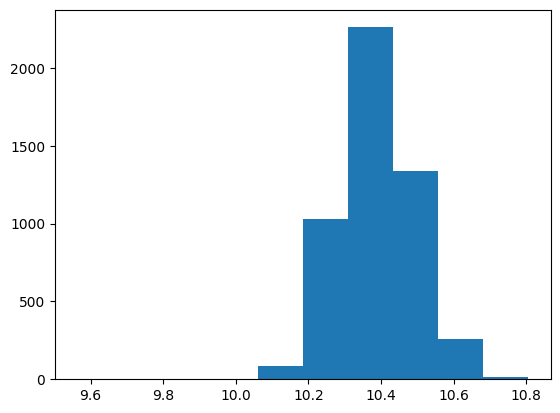

In [65]:
plot.hist(first_times)

## Timing Resolution
Need distribution of time of first photons

#### Optph: process times and get distribution

In [66]:
#Minimum number of pixels to be hit for us to accept event
threshold = 10
uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/June_11/run_1_mum_10GeV_theta_90_5kevents_1_8_time_constant.edm4hep.root:events"
# uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/May_5/run_1_mum_10GeV_theta_90_5kevents.edm4hep.root:events"
# uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/January_27/run_1_w_QE_2cm_thickness"
accepted_times, second_lowest_list, avg_accepted_times, times = process_times(uproot_path, threshold,multipleFiles=False)

total: 416442 | duplicates: 27282 | ratio: 0.06551212413733486 | num unique cells hit: 5834 | skipped: 0


In [67]:
all_times_optph = []
for event_idx in range(len(times)):
    for time in times[event_idx]:
        all_times_optph.append(time)

### Compare first photon distributions

In [68]:
np_first_times = np.array(first_times)

np_accepted_times = np.array(accepted_times)
ub = 10.8
lb = 10.2
cut_first_times = np_first_times[np_first_times < ub]
cut_first_times = cut_first_times[cut_first_times > lb]

cut_accepted_times = np_accepted_times[np_accepted_times < ub]
cut_accepted_times = cut_accepted_times[cut_accepted_times > lb]

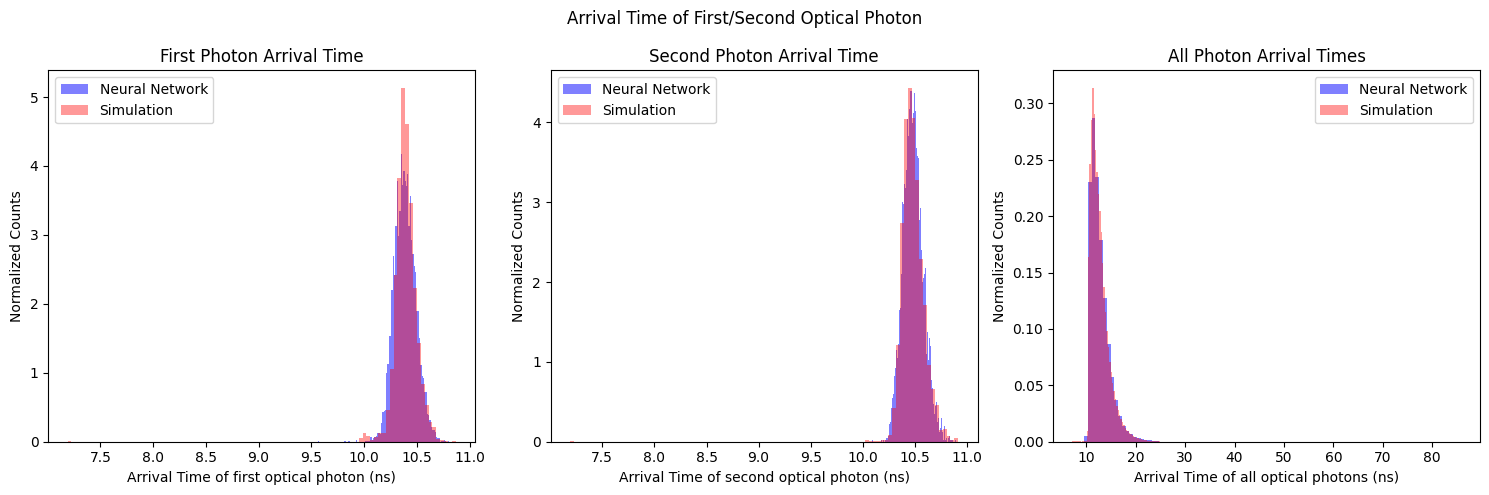

In [69]:
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 600
(mu, sigma) = norm.fit(cut_accepted_times)

fig_first_times, axs_first_times = plot.subplots(1,3,figsize=(15,5))
axs_first_times[0].hist(first_times,bins = 100,alpha = 0.5, color = "blue",density = True,label = "Neural Network");
axs_first_times[0].hist(accepted_times,bins = 100,alpha = 0.4, color = "red",density = True,label = "Simulation");
axs_first_times[0].legend()
axs_first_times[0].set_ylabel("Normalized Counts")
axs_first_times[0].set_title("First Photon Arrival Time")
axs_first_times[0].set_xlabel("Arrival Time of first optical photon (ns)")

axs_first_times[1].hist(second_times,bins = 100,alpha = 0.5, color = "blue",density = True,label = "Neural Network");
axs_first_times[1].hist(second_lowest_list,bins = 100,alpha = 0.4, color = "red",density = True,label = "Simulation");
axs_first_times[1].legend()
axs_first_times[1].set_ylabel("Normalized Counts")
axs_first_times[1].set_title("Second Photon Arrival Time")
axs_first_times[1].set_xlabel("Arrival Time of second optical photon (ns)")

axs_first_times[2].hist(samples,bins = 100,alpha = 0.5, color = "blue",density = True,label = "Neural Network");
axs_first_times[2].hist(all_times_optph,bins = 100,alpha = 0.4, color = "red",density = True,label = "Simulation");
axs_first_times[2].legend()
axs_first_times[2].set_ylabel("Normalized Counts")
axs_first_times[2].set_title("All Photon Arrival Times")
axs_first_times[2].set_xlabel("Arrival Time of all optical photons (ns)")
fig_first_times.suptitle("Arrival Time of First/Second Optical Photon")
# fig_first_times.text(0.3,0.5,r"$\sigma$ = %.1f ps"%(sigma * 1000))
fig_first_times.tight_layout()
# fig_first_times.savefig("plots/time_res/both_times_1cm_new_labels.jpeg")

## Cutting off tails

In [76]:
np_first_times = np.array(first_times)

np_accepted_times = np.array(accepted_times)

cut_first_times = np_first_times[np_first_times < 10.8]
cut_first_times = cut_first_times[cut_first_times > 10]

cut_accepted_times = np_accepted_times[np_accepted_times < 10.8]
cut_accepted_times = cut_accepted_times[cut_accepted_times > 10]

In [77]:
#timing resolution:
(mu_real, sigma_real) = norm.fit(cut_accepted_times)
(mu_learned, sigma_learned) = norm.fit(cut_first_times)
print("\tsigma:\t\t| mean:\t\t")
print("Real:\t\t  %4.3f |\t %4.2f" %(sigma_real,mu_real))
print("Learned:\t  %4.3f |\t %4.2f" %(sigma_learned,mu_learned))

	sigma:		| mean:		
Real:		  0.095 |	 10.40
Learned:	  0.102 |	 10.39


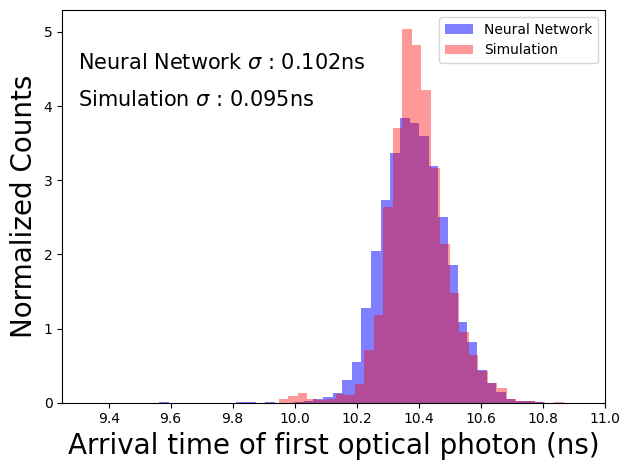

In [78]:
plot.hist(first_times,bins = 40,alpha = 0.5, color = "blue",density = True,label = "Neural Network");
plot.hist(accepted_times,bins = 120,alpha = 0.4, color = "red",density = True,label = "Simulation");
plot.legend()
plot.xlim(9.25,11)
plot.ylabel("Normalized Counts",fontsize = 20)
# plot.title("First Photon Arrival Time")
plot.xlabel("Arrival time of first optical photon (ns)",fontsize = 20)
plot.text(9.3,4,f"Simulation $\sigma$ : {sigma_real:0.3f}ns",fontsize = 15)
plot.text(9.3,4.5,f"Neural Network $\sigma$ : {sigma_learned:0.3f}ns",fontsize = 15)
plot.tight_layout()
plot.savefig("plots/NF_vs_real/NN_vs_simulation_timing_resolution_june_11_2cm_scint_1point8_ns_time_constant_smaller_model.pdf")

### Second lowest times

In [73]:
np_first_times = np.array(second_times)

np_accepted_times = np.array(second_lowest_list)

cut_first_times = np_first_times[np_first_times < 10.85]
cut_first_times = cut_first_times[cut_first_times > 10.2]

cut_accepted_times = np_accepted_times[np_accepted_times < 10.85]
cut_accepted_times = cut_accepted_times[cut_accepted_times > 10.2]
#timing resolution:
(mu_real, sigma_real) = norm.fit(cut_accepted_times)
(mu_learned, sigma_learned) = norm.fit(cut_first_times)
print("\tsigma:\t\t| mean:\t\t")
print("Real:\t\t  %4.3f |\t %4.2f" %(sigma_real,mu_real))
print("Learned:\t  %4.3f |\t %4.2f" %(sigma_learned,mu_learned))

	sigma:		| mean:		
Real:		  0.096 |	 10.48
Learned:	  0.097 |	 10.48


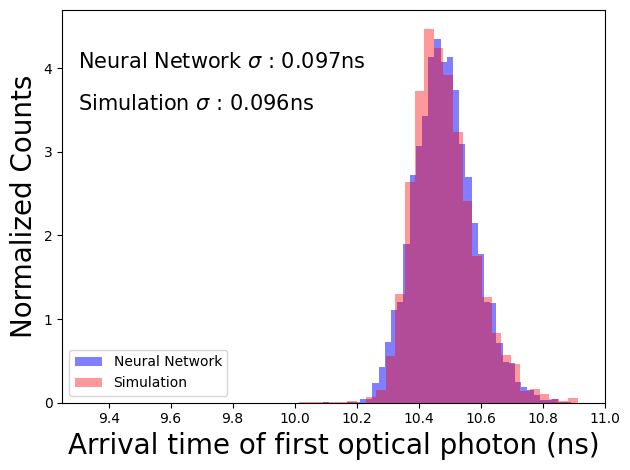

In [75]:
plot.hist(second_times,bins = 40,alpha = 0.5, color = "blue",density = True,label = "Neural Network");
plot.hist(second_lowest_list,bins = 120,alpha = 0.4, color = "red",density = True,label = "Simulation");
plot.legend()
plot.xlim(9.25,11)
plot.ylabel("Normalized Counts",fontsize = 20)
# plot.title("First Photon Arrival Time")
plot.xlabel("Arrival time of first optical photon (ns)",fontsize = 20)
plot.text(9.3,3.5,f"Simulation $\sigma$ : {sigma_real:0.3f}ns",fontsize = 15)
plot.text(9.3,4,f"Neural Network $\sigma$ : {sigma_learned:0.3f}ns",fontsize = 15)
plot.tight_layout()
plot.savefig("plots/NF_vs_real/NN_vs_simulation_timing_resolution_june_11_2cm_scint_1point8_ns_time_constant_second_photon_smaller_model.pdf")

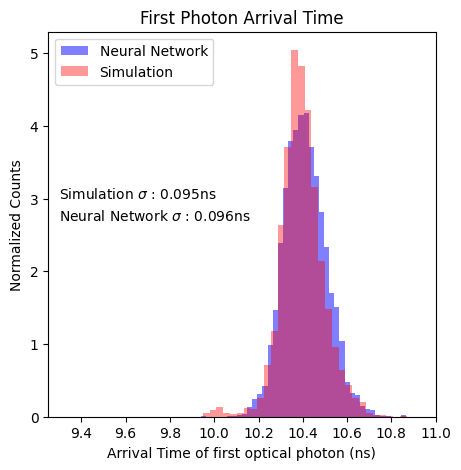

In [88]:
one_plot_fig,one_plot_axs = plot.subplots(1,1,figsize=(5,5))
one_plot_axs.hist(first_times,bins = 40,alpha = 0.5, color = "blue",density = True,label = "Neural Network");
one_plot_axs.hist(accepted_times,bins = 120,alpha = 0.4, color = "red",density = True,label = "Simulation");
one_plot_axs.legend()
one_plot_axs.set_xlim(9.25,11)
one_plot_axs.set_ylabel("Normalized Counts")
one_plot_axs.set_title("First Photon Arrival Time")
one_plot_axs.set_xlabel("Arrival Time of first optical photon (ns)")
one_plot_axs.text(9.3,3,f"Simulation $\sigma$ : {sigma_real:0.3f}ns")
one_plot_axs.text(9.3,2.7,f"Neural Network $\sigma$ : {sigma_learned:0.3f}ns")
one_plot_fig.savefig("plots/NF_vs_real/NN_vs_simulation_timing_resolution_june_11_2cm_scint_1point8_ns_time_constant.pdf")

In [23]:
#timing resolution:
accepted_times = np.array(accepted_times)

cut_accepted_times = accepted_times[accepted_times < 10.9]
cut_accepted_times = cut_accepted_times[cut_accepted_times > 10]


(mu_real, sigma_real) = norm.fit(accepted_times)
(mu_real_cut, sigma_real_cut) = norm.fit(cut_accepted_times)
print("\tsigma:\t\t| mean:\t\t")
print("Real:\t\t  %4.3f |\t %4.2f" %(sigma_real,mu_real))
print("Real cut:\t\t  %4.3f |\t %4.2f" %(sigma_real_cut,mu_real_cut))

	sigma:		| mean:		
Real:		  0.108 |	 10.40
Real cut:		  0.095 |	 10.40


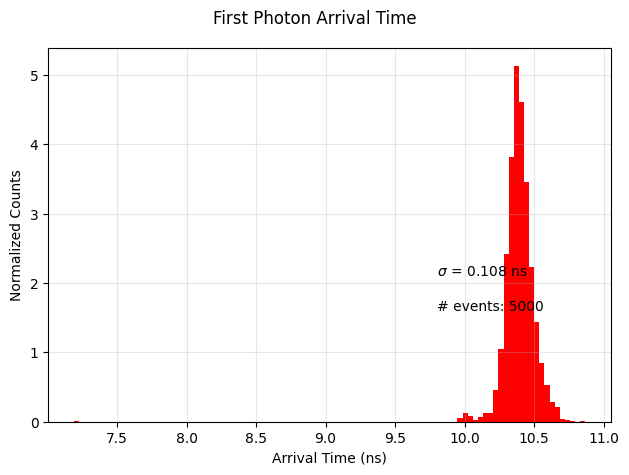

In [24]:
fig_first_times, axs_first_times = plot.subplots(1,1)
axs_first_times.hist(accepted_times,bins = 100,alpha = 1, color = "red",density = True);
# axs_first_times.legend()
axs_first_times.set_ylabel("Normalized Counts")
axs_first_times.set_xlabel("Arrival Time (ns)")
axs_first_times.text(9.8,2.1,r"$\sigma$ = %.3f ns" % (sigma_real))
axs_first_times.text(9.8,1.6,r"# events: %d" % (len(accepted_times)))
axs_first_times.grid(alpha = 0.3)
fig_first_times.suptitle("First Photon Arrival Time")
fig_first_times.tight_layout()
plot.show()
# fig_first_times.savefig("plots/sept_29/time_res_0_8_10GeV_mu_5250.pdf")